# Singoli Continenti

Dati dei singoli continenti.

> Max Pierini

***

Legenda:

- Cumulativi
    - Rosso: deceduti
    - Verde: guariti
    - Blu: positivi

- $R_t$
    - Rosso: maggiore di 1
    - Verde: minore di 1

In [1]:
import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date

from IPython.display import Markdown, display, Math
import pandas as pd

import arviz as az
import pyjags

In [2]:
data = {}

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-WORLD.json"
_data = pd.read_json(json_url)
data.update({"WORLD": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-AFRICA.json"
_data = pd.read_json(json_url)
data.update({"Africa": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-ASIA.json"
_data = pd.read_json(json_url)
data.update({"Asia": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-EUROPE.json"
_data = pd.read_json(json_url)
data.update({"Europe": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-NORTH_AMERICA.json"
_data = pd.read_json(json_url)
data.update({"North America": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-SOUTH_AMERICA.json"
_data = pd.read_json(json_url)
data.update({"South America": _data})

json_url = "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-OCEANIA.json"
_data = pd.read_json(json_url)
data.update({"Oceania": _data})
    
# LOCKDOWNS
_ = """
ld = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/lockdowns.csv",
    dtype={"Place": str}
)
ld.fillna('', inplace=True)"""

In [3]:
days = data['WORLD'].index

In [4]:
_ = """print(f"FIRST ENTRY DATE: {days[0]}")
print(f"LAST  ENTRY DATE: {days[-1]}")
period = (days[-1] - days[0]).days

print("COVERAGE: {} days".format(period))
print("CURRENT DATE IS: {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))"""

In [5]:
SI_mu = 7.5
SI_sd = 3.4

modelString = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 0.001 , 0.001 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
}}
"""

In [6]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

In [7]:
adapt = 100
warmup = 500
sample = 500

# WORLD

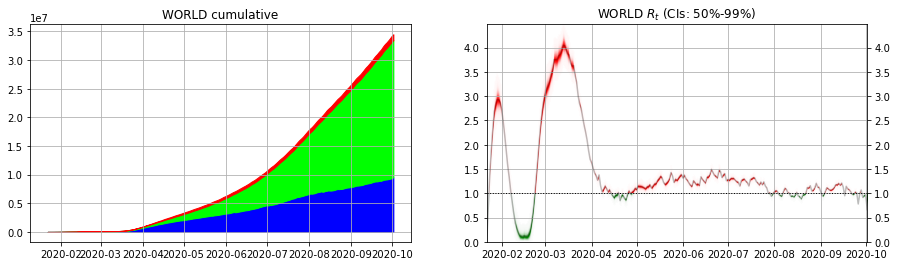

***

# Africa

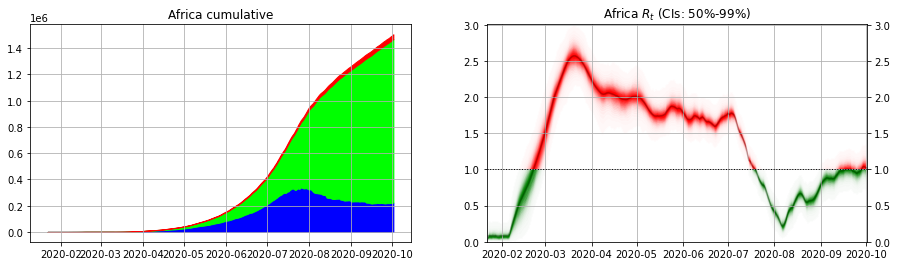

***

# Asia

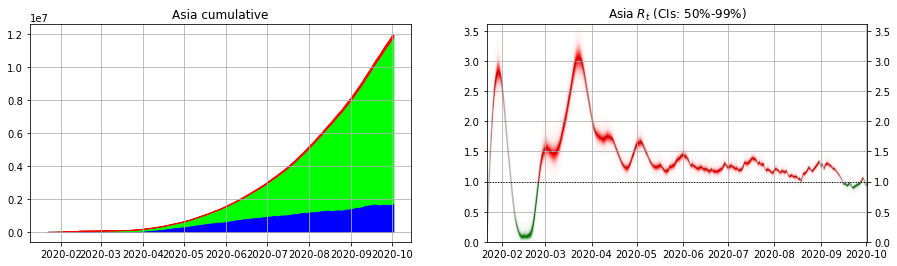

***

# Europe

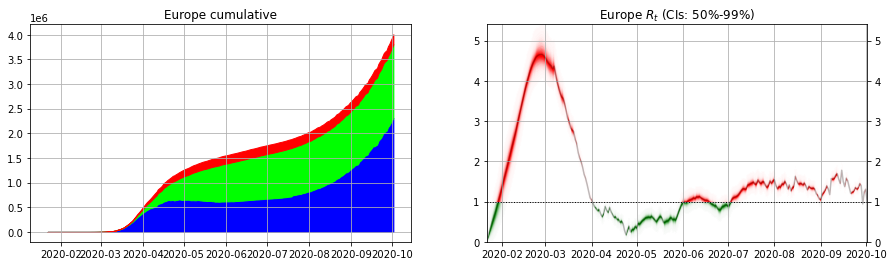

***

# North America

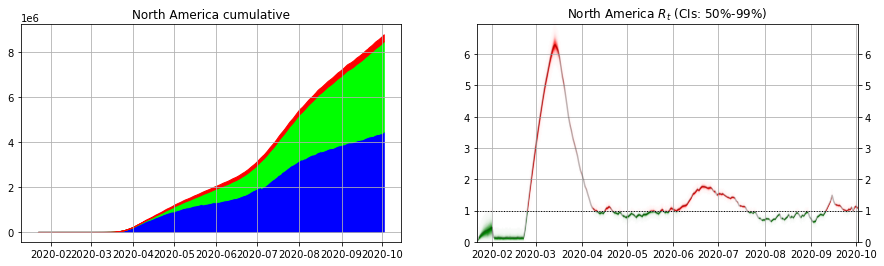

***

# South America

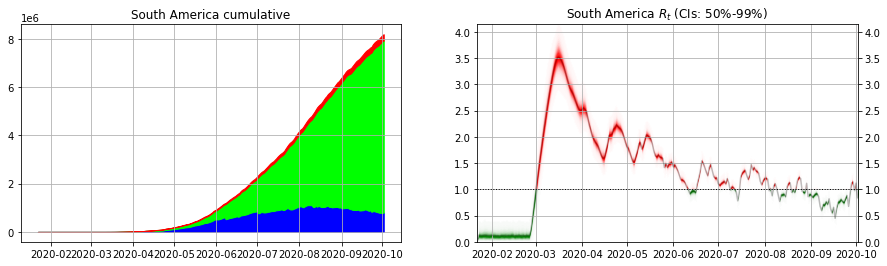

***

# Oceania

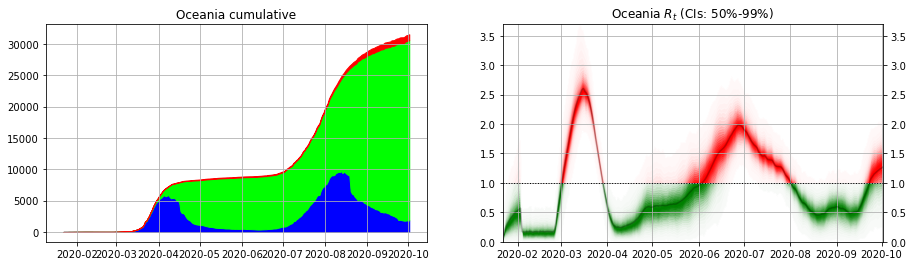

***

In [8]:
for continent in data:
    display(Markdown(f"# {continent}"))
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    t = data[continent]['Confirmed']
    d = data[continent]['Deaths']
    r = data[continent]['Recovered']
    p = t - r - d
        
    ax[0].fill_between(days, 0, p, color='blue')
    ax[0].fill_between(days, p, p+r, color='#00ff00')
    ax[0].fill_between(days, p+r, p+r+d, color='red')
    ax[0].set_title(f"{continent} cumulative")
    ax[0].grid()
        
    filtered_t, t_ouliers = hampel_filter_pandas(t.diff(), 7, 2)

    smoothed = filtered_t.rolling(14,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=5).round()

    model_data = {
        "y": smoothed.values,
        "k": smoothed.values,
        "T": days.size,
    }
    
    jags_posteriors_italy = None

    jags_model = pyjags.Model(
        code=modelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=["sigma_R", "R",]
    )

    percs = np.linspace(50, 99, 20)

    ymax = np.array([])
    uppers = np.ndarray(shape=(len(percs), days.size))
    lowers = np.ndarray(shape=(len(percs), days.size))

    pyjags_data = az.from_pyjags(jags_posteriors, warmup_iterations=warmup, save_warmup=False)
    summary = az.summary(pyjags_data, var_names="R", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper.max())
        uppers[i] = upper
        lowers[i] = lower

    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers, lowers)):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax[1].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax[1].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax[1].plot(days, summary["mean"], c="k", alpha=.25)

    ax[1].axhline(1, c="k", ls=":", lw=1)

    ax[1].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
    ax[1].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

    ax[1].set_xlim(days[0], days[-1])

    ax[1].set_title(fr"{continent} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

    ax[1].set_ylim(0, ymax.max())
    ax[1].yaxis.set_ticks_position('both')
    ax[1].tick_params(labelright=True)
    ax[1].grid()
    
    fig.set_facecolor('w'); plt.show();
    plt.close(fig='all')
    display(Markdown("***"))